In [75]:
import json
import  pickle
import joblib
import optuna
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy  as np
import pandas as pd
import tqdm
import time

from sklearn.cluster import KMeans
from eval_utils import *
from models_gaussian import GaussianDenseHMM, HMMLoggingMonitor, DenseHMMLoggingMonitor
from models_gaussian_A import GaussianDenseHMM as CoocHMM
from hmmlearn import hmm


In [76]:
t = time.localtime()
RESULT_DIR = f'gaussian_dense_hmm_benchmark/eval-cooc-{t.tm_year}-{t.tm_mon}-{t.tm_mday}'

We have examined the efficiency of co-occurence based learning methods for Gaussian HMM. This notebook contains a comparison of:

- standard Gaussian Hidden Markov Model implementation,
- co-occurrence based larning for Gaussian Hidden Markov Model,
- EM learning for GaussianDenseHHMM,
- co-occurrence based learning for GaussianDenseHMM.

The dense representation was examined with fixed and tuned embedding length.

In [77]:
n = 8
s = 100
T = 1000
simple_model = True

In [78]:
l_fixed = True

RESULT_DIR = f'gaussian_dense_hmm_benchmark/eval-cooc-{t.tm_year}-{t.tm_mon}-{17}'
with open(f"{RESULT_DIR}/optuna_cooc_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.pkl", "rb") as f:
    study = joblib.load(f)

In [79]:
study_res = pd.DataFrame([{**t.params, "mean": t.values[0], "std": t.values[1]} for t in study.trials])
study_res

,cooc_lr_param,cooc_epochs_param,mean,std
0,0.007055,95252,-1.029042e+08,4.989413e+07
1,0.000372,22013,-1.258788e+08,8.937642e+07
2,0.016005,14357,-6.724162e+07,1.405187e+07
3,0.315334,94224,-8.523348e+07,6.216957e+07
4,0.054786,15321,-8.100231e+07,1.229705e+07
5,0.001338,61685,-1.059174e+08,5.560698e+07
6,0.000292,54599,-6.600827e+07,9.538663e+06
7,0.070272,71114,-7.066690e+07,3.602548e+07
8,0.312263,43095,-7.776879e+07,1.773118e+07
9,0.000237,26975,-8.915181e+07,4.766469e+07


<AxesSubplot:xlabel='mean', ylabel='std'>

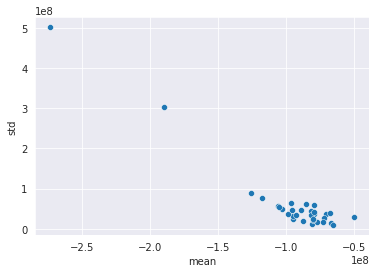

In [80]:
sns.scatterplot(data=study_res, x="mean", y="std")

In [81]:
best_params = dict()
# best_params["cooc"] = study_res.sort_values("mean").iloc[-1, :2].to_dict()
best_params["cooc"] = study_res.sort_values("std").iloc[1, :2].to_dict()
best_params["cooc"]['cooc_epochs_param'] = int(best_params["cooc"]['cooc_epochs_param'])
best_params["cooc"]['l_param'] = int(np.ceil(n / 3))
best_params

{'cooc': {'cooc_lr_param': 0.054785912200337884,
  'cooc_epochs_param': 15321,
  'l_param': 3}}

In [82]:
best_result = {}
s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, _, em_scheduler = init_experiment((s, T, n), simple_model)
nodes = np.concatenate([np.array([-np.infty, Y_true.min()]),
                        (mu[1:] + mu[:-1]) / 2,
                        np.array([Y_true.max(), np.infty])])
m = nodes.shape[0] - 1

models = dict(cooc=CoocHMM, dense=GaussianDenseHMM, dense_em=GaussianDenseHMM)
monitors = dict(cooc=DenseHMMLoggingMonitor, dense=DenseHMMLoggingMonitor, dense_em=DenseHMMLoggingMonitor)
algs = dict(cooc="cooc", dense="cooc", dense_em="em")

## Tune hyper-parameters
l = np.ceil(n / 3) if l_fixed else None

In [83]:
lengths = np.array(lengths)

In [84]:
def _lengths_iterator(seqs, lengths):
    n_seqs = len(lengths)
    left, right = 0, 0

    for i in range(len(lengths)):
        right += lengths[i]
        yield seqs[left:right]
        left += lengths[i]

In [87]:
## Evaluate models

true_values = {
    "states": X_true,
    "transmat": A,
    "startprob": pi,
    "means": mu,
    "covars": sigma
}

# HMMlearn
best_result["HMMlearn"] = list()
wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                             "name": f"HMMlearn"})
wandb_params["config"].update(dict(model="HMMlearn", m=0, l=0, lr=0,
                                   em_iter=em_iter(n), cooc_epochs=0,
                                   epochs=0), scheduler=False, simple_model=simple_model)
nodes_tmp = mu
nodes = np.concatenate([np.array([-np.infty, Y_true.min()]),
                        (nodes_tmp[1:] + nodes_tmp[:-1]).reshape(-1) / 2,
                        np.array([Y_true.max(), np.infty])])
Y_disc = (Y_true > nodes[1:].reshape(1, -1)).sum(axis=-1).reshape(-1, 1)

# for _ in range(10):
for _ in range(2):
    hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    hmm_model = hmm.GaussianHMM(n, n_iter=em_iter(n))
    hmm_model.monitor_ = hmm_monitor
    hmm_model.fit(Y_true, lengths)

    preds = hmm_model.predict(Y_true, lengths)
    perm = find_permutation(preds, X_true)

    best_result["HMMlearn"].append(
        {
            "time": time.perf_counter() - hmm_monitor._init_time,
            "logprob": hmm_model.score(Y_true, lengths),
            "acc": (X_true == np.array([perm[i] for i in preds])).mean(),
            "dtv_transmat": dtv(hmm_model.transmat_, A[perm, :][:, perm]),
            "dtv_startprob": dtv(hmm_model.startprob_, pi[perm]),
            "MAE_means": (abs(mu[perm] - hmm_model.means_[:, 0])).mean(),
            "MAE_sigma": (abs(sigma.reshape(-1)[perm] - hmm_model.covars_.reshape(-1))).mean(),
            "dtv_omega": dtv(empirical_cooc_prob(Y_disc, n+2, lengths),
                             normal_cooc_prob(hmm_model.means_.reshape(-1), hmm_model.covars_.reshape(-1), nodes[1:], A))
        }
    )

# Custom models
for name in tqdm.tqdm(["cooc", "dense", "dense_em"],  desc="Model building"):
    model = models[name]
    monitor = monitors[name]
    alg = algs[name]
    params = best_params[name]
    best_result[name] = list()
    wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                                 "name": f"name-l={params['l_param']}-lr={params['cooc_lr_param']}-epochs={params['cooc_epochs_param']}"})
    wandb_params["config"].update(dict(model="dense_cooc", m=0, l=int(params['l_param']), lr=params['cooc_lr_param'],
                                       em_iter=em_iter(n), cooc_epochs=params['cooc_epochs_param'],
                                       epochs=params['cooc_epochs_param']), scheduler=True,
                                  simple_model=simple_model)

    # for _ in tqdm.tqdm(range(10), desc=f"Training {name}"):
    for _ in tqdm.tqdm(range(2), desc=f"Training {name}"):
        hmm_monitor = monitor(tol=TOLERANCE, n_iter=0, verbose=True,
                              wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                              log_config={'metrics_after_convergence': True})
        # kmeans = KMeans(n_clusters=n, random_state=0).fit(Y_true)
        densehmm = model(n, mstep_config={'cooc_epochs': params['cooc_epochs_param'],
                                          'cooc_lr': params['cooc_lr_param'],
                                          "l_uz": int(params['l_param']),
                                          'loss_type': 'square',
                                          'scheduler': em_scheduler},
                         covariance_type='diag', logging_monitor=hmm_monitor, nodes=nodes,
                         init_params="", params="stmc", early_stopping=False, opt_schemes={"cooc"},
                         discrete_observables=m)
        if alg == "cooc":
            densehmm.fit_coocs(Y_true, lengths)
        else:
            densehmm.fit(Y_true, lengths)

        preds = densehmm.predict(Y_true, lengths)
        perm = find_permutation(preds, X_true)

        best_result[name].append(
            {
                "time": time.perf_counter() - hmm_monitor._init_time,
                "logprob": densehmm.score(Y_true, lengths),
                "acc": (X_true == np.array([perm[i] for i in preds])).mean(),
                "dtv_transmat": dtv(densehmm.transmat_, A[perm, :][:, perm]),
                "dtv_startprob": dtv(densehmm.startprob_, pi[perm]),
                "MAE_means": (abs(mu[perm] - densehmm.means_[:, 0])).mean(),
                "MAE_sigma": (abs(sigma.reshape(-1)[perm] - densehmm.covars_.reshape(-1))).mean(),
                "dtv_omega": dtv(empirical_cooc_prob(Y_disc, n+2, lengths),
                                  normal_cooc_prob(densehmm.means_.reshape(-1), densehmm.covars_.reshape(-1), nodes[1:], A))
            }
        )

with open(f"{RESULT_DIR}/best_result_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.json", "w") as f:
    json.dump(best_result, f, indent=4)

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁
covars_mae,▁▂▃▃▄▅▅▆▆▇▇█
means_mae,▁▂▃▃▄▅▅▆▆▇▇█
omage_dtv,█▅▃▂▂▂▂▁▁▁▁▁
startprob_dtv,█▅▄▃▂▂▂▁▁▁▁▁
time,▁▂▂▃▄▄▅▅▆▇▇█
total_log_prob,▁▁▂▂▃▃▄▅▆▆▇█
transmat_dtv,▁▁▃▄▅▅▆▇▇▇██
accuracy,0.17199
covars_mae,1.31385
means_mae,32.50394


         1     -465740.7238             +nan
         2     -451053.6455      +14687.0783
         3     -448195.6657       +2857.9798
         4     -445687.3811       +2508.2846
         5     -443554.8025       +2132.5786
         6     -441617.8082       +1936.9943
         7     -439668.1884       +1949.6198
         8     -437461.7165       +2206.4719
         9     -434716.0473       +2745.6692
        10     -431175.4293       +3540.6180
        11     -426687.4388       +4487.9906
        12     -422868.2754       +3819.1634
        13     -420990.6213       +1877.6541
        14     -419960.1885       +1030.4328
        15     -419163.6676        +796.5209
        16     -418415.3289        +748.3388
        17     -417641.2808        +774.0481
        18     -416775.0295        +866.2513
        19     -415698.6308       +1076.3988
        20     -414125.9878       +1572.6429
        21     -411189.5400       +2936.4478
        22     -403791.3646       +7398.1754
        23

time,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█████
time,37.74375
total_log_prob,-300784.48649


         1     -465740.7238             +nan
         2     -451053.6455      +14687.0783
         3     -448195.6657       +2857.9798
         4     -445687.3811       +2508.2846
         5     -443554.8025       +2132.5786
         6     -441617.8082       +1936.9943
         7     -439668.1884       +1949.6198
         8     -437461.7165       +2206.4719
         9     -434716.0473       +2745.6692
        10     -431175.4293       +3540.6180
        11     -426687.4388       +4487.9906
        12     -422868.2754       +3819.1634
        13     -420990.6213       +1877.6541
        14     -419960.1885       +1030.4328
        15     -419163.6676        +796.5209
        16     -418415.3289        +748.3388
        17     -417641.2808        +774.0481
        18     -416775.0295        +866.2513
        19     -415698.6308       +1076.3988
        20     -414125.9878       +1572.6429
        21     -411189.5400       +2936.4478
        22     -403791.3646       +7398.1754
        23

time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█████
time,36.0299
total_log_prob,-300784.48649


         1   -59304407.5556             +nan
         2   -53995640.0644    +5308767.4912
         3   -49880739.1552    +4114900.9091
         4   -46634768.9972    +3245970.1580
         5   -43873651.4138    +2761117.5835
         6   -41419798.1333    +2453853.2805
         7   -39316183.0052    +2103615.1281
         8   -37547873.4128    +1768309.5924
         9   -35719105.0342    +1828768.3786
        10   -33928847.2980    +1790257.7362
        11   -32360408.3736    +1568438.9244
        12   -31012835.4454    +1347572.9281
        13   -29790092.0429    +1222743.4025
        14   -28642178.4330    +1147913.6099
        15   -27607530.7020    +1034647.7310
        16   -26696377.5791     +911153.1230

Training cooc:  50%|███████████████               | 1/2 [00:46<00:46, 46.60s/it]

accuracy,▄▁██████████████
covars_mae,▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
means_mae,▁▅▅▅▅▅▅▅████████
omage_dtv,█▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁
startprob_dtv,█▄▄▃▂▁▁▁▃▃▃▃▃▃▃▃
time,▁▁▂▂▃▃▄▄▅▅▆▆▇▇▇█
total_log_prob,▁▂▃▄▄▅▅▆▆▆▇▇▇███
transmat_dtv,▄█▆▆▆▆▇▇▁▁▁▁▁▂▂▂
accuracy,0.17199
covars_mae,5.88019
means_mae,24.9874


         1   -60169256.9277             +nan
         2   -47222914.8750   +12946342.0527
         3   -39782188.6839    +7440726.1912
         4   -34859402.6034    +4922786.0805
         5   -31207508.7559    +3651893.8475
         6   -28312825.6106    +2894683.1452
         7   -26053851.5034    +2258974.1073
         8   -24289365.4003    +1764486.1031
         9   -22811640.1206    +1477725.2797
        10   -21519417.1804    +1292222.9402
        11   -20426009.2917    +1093407.8887
        12   -19514505.1160     +911504.1757
        13   -18709346.3943     +805158.7217
        14   -17972356.7995     +736989.5949
        15   -17323952.0466     +648404.7529
        16   -16765727.5770     +558224.4696

Model building:  33%|█████████▋                   | 1/3 [01:33<03:07, 93.96s/it]


KeyError: 'dense'

In [ ]:
# Provide data
all_files = os.listdir(RESULT_DIR)

results = [s for s in all_files if len(s.split("_")) == 6]
studies = [s for s in all_files if len(s.split("_")) == 7]

cases = list(set(["_".join(s.split("_")[1:-1]) for s in studies]))

In [ ]:
# read all data
experiment = dict(studies  =dict(l_fixed=dict(),  l_tuned=dict()),
                  summaries=dict(l_fixed=dict(),  l_tuned=dict()))

In [ ]:
for c in cases:
    with open(f"{RESULT_DIR}/optuna_{c}_lTrue.pkl", "rb") as f:
        experiment["studies"]["l_fixed"][c] = joblib.load(f)
    with open(f"{RESULT_DIR}/optuna_{c}_lFalse.pkl", "rb") as f:
        experiment["studies"]["l_tuned"][c] = joblib.load(f)
    with open(f"{RESULT_DIR}/best_result_{c}_lTrue.json", "r") as f:
        experiment["summaries"]["l_fixed"][c] = json.load(f)
    with open(f"{RESULT_DIR}/best_result_{c}_lFalse.json", "r") as f:
        experiment["summaries"]["l_tuned"][c] = json.load(f)

## Compare tunning methods

In [ ]:
# Variable importance
for c in cases:
    display(optuna.visualization.plot_param_importances(experiment["studies"]["l_fixed"][c],
                                                        target=lambda t: t.values[0], target_name="flops",  title="Fixed"))
    display(optuna.visualization.plot_param_importances(experiment["studies"]["l_tuned"][c],
                                                        target=lambda t: t.values[0], target_name="flops", title="Tuned"))

In [ ]:
# l zafixowane versus wyniki hiperparametryzacji zależnie od l
for c in cases:
    no_trials = len(experiment["studies"]["l_fixed"][c].trials)
    x = [experiment["studies"]["l_fixed"][c].trials[i].params['l_param'] for i in range(no_trials)]
    y = [experiment["studies"]["l_fixed"][c].trials[i].values[0] for i in range(no_trials)]
    name = cases.split("_")[0]
    sns.violinplot(x, y)
    plt.xlabel("l")
    plt.ylabel("log-likelihood")
    plt.title(f"{name} (when fixed l={int(np.ceil(8 / 3))})")
    plt.show()

In [ ]:
# s, T, n, simple_model = 100, 40, 4, True
#
# with open(f"gaussian_dense_hmm_benchmark/fit_coocs_ll_mini-2022-8-12/optuna_s{s}_T{T}_n{n}_simple_model{simple_model}.pkl",  "rb") as f:
#     study = joblib.load(f)

## Compare  results of all methods

In [ ]:
# with open(f"gaussian_dense_hmm_benchmark/fit_coocs_ll_mini-2022-8-12/best_result_s{s}_T{T}_n{n}_simple_model{simple_model}.json",  "r") as f:
#     best_results = json.load(f)

In [ ]:
#  tabularise results
for c in cases:
    display(f'\n\n### {" ".join(c.split("_"))}')
    display(pd.DataFrame(experiment["summaries"]["l_fixed"][c]).style.set_caption("l fixed"))
    display(pd.DataFrame(experiment["summaries"]["l_tuned"][c]).style.set_caption("l tuned"))


## Train co-oc + EM

In [ ]:
# Use the same parameters and provide time benchmarks

In [ ]:
s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data, em_scheduler = init_experiment(dsize=(100, 100, 8), simple_model=True)


def to_discrete(X, m):
    kmeans = KMeans(n_clusters=m, random_state=0).fit(Y_true)
    nodes_tmp = np.sort(kmeans.cluster_centers_, axis=0)
    nodes = np.concatenate([(nodes_tmp[1:] + nodes_tmp[:-1]) / 2, np.array([[np.infty]])])
    return (X > nodes.reshape(1, -1)).sum(axis=-1).reshape(-1, 1), nodes.reshape(-1)


Y_disc, nodes = to_discrete(Y_true, m=n)

In [ ]:
for  _  in range(10):
    # TODO: read parameters from dense cooc and dense em
    cooc_params = experiment["studies"]["l_fixed"][c].best_params  # TODO: c
    em_params   = experiment["studies"]["l_fixed"][c].best_params  # TODO: c
    mstep_cofig = {"cooc_lr": cooc_params['cooc_lr_param'],
                   "cooc_epochs": cooc_params['cooc_epochs_param'],
                   "l_uz": cooc_params['l_param'],
                   "em_params":  em_params['cooc_lr_param'],
                   "em_epochs": em_params['cooc_epochs_param'],
                   "loss_type": 'square',
                   "scheduler": em_scheduler}
    wandb_params["init"].update({"name": f"dense-cooc+em"})
    hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                                covariance_type='diag', opt_schemes={"cooc"},
                                nodes=np.concatenate([np.array([-np.infty]), nodes]),
                                discrete_observables=n, em_iter=20,
                                logging_monitor=hmm_monitor,
                                init_params="", params="stmc", early_stopping=True)
    densehmm.means_ = mu.reshape(-1, 1)
    start = time.perf_counter()
    densehmm.fit_coocs(Y_true, lengths)
    densehmm.fit(Y_true, lengths)
    time_tmp = time.perf_counter() - start

#  Results in wanbd